# 神经网络学习“你拍我猜” —— 你拍照，AI 猜

在这个项目中，你将学习利用神经网络来分类照片中是狗狗，是猫猫，还是人。

本项目使用了一个经过预处理后较小的数据集，数据集中仅含有图像的特征结果。对于如何获取图像的特征，这里附上了 open cv 中对于图像特征的说明。
http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_meaning/py_features_meaning.html


在该 notebook 中，我们基于以下三个特征来了解图像是狗狗，猫猫还是人的概率：

- Feature1
- Feature2
- Feature3
- Feature4

‘class’ 是 0，代表是人；1 代表是猫猫；2 代表是狗狗；

每一行代表一个图像；

## 加载数据

为了加载数据并很好地进行格式化，我们将使用两个非常有用的包，即 Pandas 和 Numpy。 你可以在这里阅读文档：

- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [1]:
%matplotlib inline
# Importing pandas and numpy
import pandas as pd
import numpy as np
from IPython.display import display
 # present all plots in the notebook

# Reading the csv file into a pandas DataFrame
dataset = pd.read_csv('data.csv')

#random all the rows in dataset
dataset = dataset.sample(frac=1)

# print data shortcut
dataset[:10]

,feature1,feature2,feature3,feature4,class
12,4.8,1200.0,1.4,1.0,0
145,6.7,1200.0,5.2,23.0,2
110,6.5,1280.0,5.1,20.0,2
59,5.2,1080.0,3.9,14.0,1
116,6.5,1200.0,5.5,18.0,2
129,7.2,1200.0,5.8,16.0,2
32,5.2,1640.0,1.5,1.0,0
128,6.4,1120.0,5.6,21.0,2
114,5.8,1120.0,5.1,24.0,2
66,5.6,1200.0,4.5,15.0,1


## 数据分析 - 绘制数据，可视化的数据分析


首先让我们对数据进行绘图，看看他们互相之间的关系是什么。首先来看试一下 feature1 和 feature2

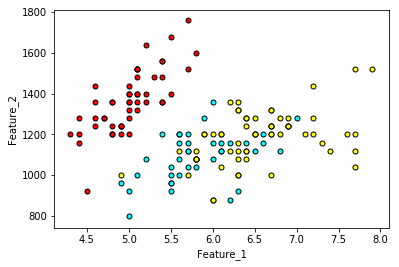

In [2]:
# Importing matplotlib
import matplotlib.pyplot as plt

# Function to help us plot
def plot_points(dataset):
    X = np.array(dataset[["feature1","feature2"]])
    y = np.array(dataset["class"])
    
    people = X[np.argwhere(y==0)]
    cat = X[np.argwhere(y==1)]
    dog = X[np.argwhere(y==2)]
    
    plt.scatter([s[0][0] for s in people], [s[0][1] for s in people], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in cat], [s[0][1] for s in cat], s = 25, color = 'cyan', edgecolor = 'k')
    plt.scatter([s[0][0] for s in dog], [s[0][1] for s in dog], s = 25, color = 'yellow', edgecolor = 'k')
    
    plt.xlabel('Feature_1')
    plt.ylabel('Feature_2')
    
# Plotting the points
plot_points(dataset)
plt.show()

图上红色是人，青色是小猫，黄色是小狗。
粗略来说，这两个 feature 并没有很好地分离图像小狗，小猫和人。 也许将另两个features考虑进来会有帮助？ 
接下来我们将绘制一组图，用 seaborn 的 pairplot 函数来试试吧！

https://seaborn.pydata.org/generated/seaborn.pairplot.html

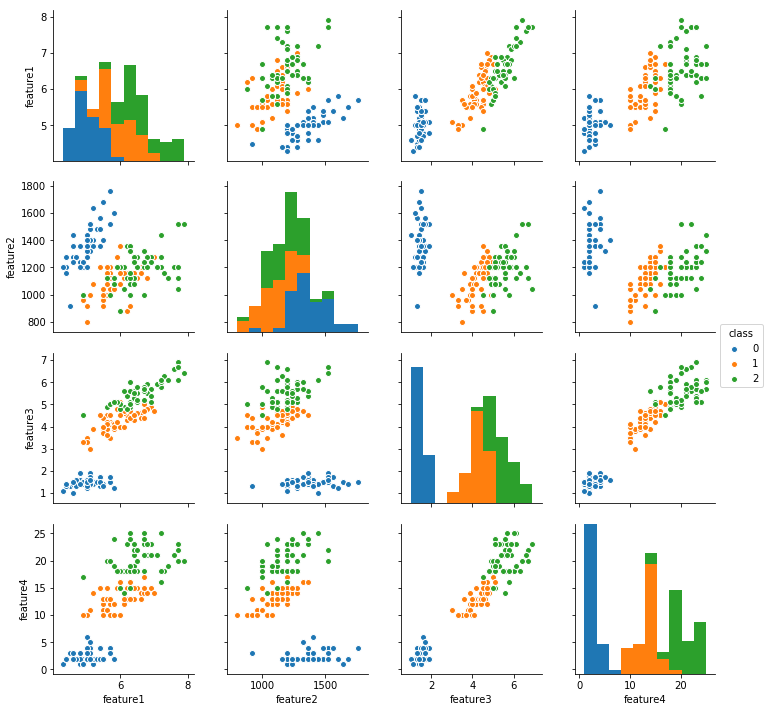

In [3]:
# plotting high-dimensional
import seaborn as sns

sns.pairplot(dataset, hue='class', vars=["feature1","feature2","feature3","feature4"])

图上class=0，代表是人；1代表是猫猫；2代表是狗狗；

## 任务1: 将训练集拆分成自变量 data 及因变量标签 label 的组合

数据集中 ['feature1','feature2','feature3','feature4'] 是自变量 data；

['class'] 则是因变量标签 label；

可参考使用 pandas 中的 iloc，loc 用法。

https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.iloc.html

https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.loc.html

In [4]:
# separate dataset into data - feature table and label table
data = dataset.loc[:,'feature1':'feature4']
label = dataset['class']

display(data[:10])
display(label[:10])

,feature1,feature2,feature3,feature4
12,4.8,1200.0,1.4,1.0
145,6.7,1200.0,5.2,23.0
110,6.5,1280.0,5.1,20.0
59,5.2,1080.0,3.9,14.0
116,6.5,1200.0,5.5,18.0
129,7.2,1200.0,5.8,16.0
32,5.2,1640.0,1.5,1.0
128,6.4,1120.0,5.6,21.0
114,5.8,1120.0,5.1,24.0
66,5.6,1200.0,4.5,15.0


12     0
145    2
110    2
59     1
116    2
129    2
32     0
128    2
114    2
66     1
Name: class, dtype: int64

## 任务2: 将分类进行 One-hot 编码

为了实现 softmax 的概率分布，我们将使用Pandas 中的 `get_dummies` 函数来对 label 进行One-hot编码。

### 问题1: One-hot 编码的作用是什么呢？

回答：

One-hot 编码专门用来表示多结果类别的情况，通过给每种类别设定一个独立的变量来数字化这些类别时，也避免了引入各类别之间不存在的相关性

In [5]:
# Done:  Make dummy variables for labels
dummy_label = pd.get_dummies(label)

# Print the first 10 rows of our data
dummy_label[:10]

,0,1,2
12,1,0,0
145,0,0,1
110,0,0,1
59,0,1,0
116,0,0,1
129,0,0,1
32,1,0,0
128,0,0,1
114,0,0,1
66,0,1,0


## 任务3: 数据标准化


由于神经网络是计算权重，因此我们需要对数据进行标准化的预处理。
我们注意到 feature2 和 feature4 的范围比 feature1 和 feature3 要大很多，这意味着我们的数据存在偏差，使得神经网络很难处理。 让我们将两个特征缩小，使用 (x - min)/(max - min)) 来将特征归到 (0, 1)。

---

**Twentynight Notes**:

如果使用直接除以最大值来标准化特征，即使用 x/max ，很可能会导致标准化之后的值之间区别不大，比如数据的取值范围是 93 到 94 之间，直接除以最大值标准化后，数据的取值范围变为是 0.93~0.94 之间，数据间的差异会变得非常模糊不清

In [6]:
# 标准化 'feature2' 和 'feature4' 这两列之前，先储存各列最小值和各列的取值区间，因为最终实战预测的时候要使用
# 之所以实战预测要使用，是因为我们的预测模型是基于下面这些最小值和区间训练出来的，所以实战预测时也必须使用这些数据来标准化相应的列
min_feature = {'feature2': data['feature2'].min(), 'feature4': data['feature4'].min()} 
range_feature = {'feature2': (data['feature2'].max() - data['feature2'].min()),
                 'feature4': (data['feature4'].max() - data['feature4'].min())}

# Done: Scale the columns
data['feature2'] = (data['feature2'] - min_feature["feature2"])/range_feature["feature2"]
data['feature4'] = (data['feature4'] - min_feature["feature4"])/range_feature["feature4"]

# Printing the first 10 rows of our procesed data
data[:10]

,feature1,feature2,feature3,feature4
12,4.8,0.416667,1.4,0.000000
145,6.7,0.416667,5.2,0.916667
110,6.5,0.500000,5.1,0.791667
59,5.2,0.291667,3.9,0.541667
116,6.5,0.416667,5.5,0.708333
129,7.2,0.416667,5.8,0.625000
32,5.2,0.875000,1.5,0.000000
128,6.4,0.333333,5.6,0.833333
114,5.8,0.333333,5.1,0.958333
66,5.6,0.416667,4.5,0.583333


## 任务4: 将数据分成训练集和测试集

为了测试我们的算法，我们将数据分为训练集和测试集。 测试集的大小将占总数据的 10％。

你可以使用 numpy.random.choice 或者 sklearn.model_selection.train_test_split 函数。

https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

#### 问题2: 拆分测试集的目的是什么？还有其他的拆分方式吗？

你的回答：

拆分测试集的目的是获取「测试数据集合」，进而可以让我们输入最终的预测模型，评估它的预测效果。是的，还有其他的拆分方式，比如 $k$ 折交叉验证法（k-fold cross-validation）中，「训练集」会被进一步拆分成多个数据组，然后轮流做「验证集」训练数据。

In [7]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split
# Done: split train and test dataset
train_data, test_data, train_label, test_label = train_test_split(data, dummy_label, test_size = 0.1, random_state = 29)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])
print(train_label[:10])
print(test_label[:10])

Number of training samples is 135
Number of testing samples is 15
     feature1  feature2  feature3  feature4
70        5.9  0.500000       4.8  0.708333
81        5.5  0.166667       3.7  0.375000
57        4.9  0.166667       3.3  0.375000
40        5.0  0.625000       1.3  0.083333
69        5.6  0.208333       3.9  0.416667
87        6.3  0.125000       4.4  0.500000
149       5.9  0.416667       5.1  0.708333
114       5.8  0.333333       5.1  0.958333
14        5.8  0.833333       1.2  0.041667
50        7.0  0.500000       4.7  0.541667
     feature1  feature2  feature3  feature4
46        5.1  0.750000       1.6  0.041667
100       6.3  0.541667       6.0  1.000000
18        5.7  0.750000       1.7  0.083333
78        6.0  0.375000       4.5  0.583333
110       6.5  0.500000       5.1  0.791667
112       6.8  0.416667       5.5  0.833333
109       7.2  0.666667       6.1  1.000000
122       7.7  0.333333       6.7  0.791667
105       7.6  0.416667       6.6  0.833333
84        

## 任务5: 训练多分类的神经网络
下列函数会训练二层神经网络。 首先，我们将写一些 helper 函数。
- Softmax 激活函数

$$\sigma(x) = \frac{e^{x_i}} {\sum_{i=1}^{p} e^{x_i}}$$

p 指代 x 的特征数量；

softmax 函数常用于多分类目标的模型，他会把所有的 output 对 sum(output) 进行均一化，用于减少模型预测偏差。https://zh.wikipedia.org/wiki/Softmax%E5%87%BD%E6%95%B0

sigmoid 函数常用于二分类目标的模型，他会将离散数值转换为概率数值。https://zh.wikipedia.org/wiki/S%E5%87%BD%E6%95%B0

- 误差函数 ：交叉熵

$$ loss = - {\sum_{i=1}^{m} ({y_i} * \log{\hat{y_i}})}$$

m 为分类的类别数。

---

**Twentynight Notes**:

$\hat{y_i}$ 算出来的是对于第 $i$ 个点（图像），各个类别的概率: $\hat{y_i} = (\hat{y_i}^{人},\hat{y_i}^{猫},\hat{y_i}^{狗})$，而 $y_i$ 则明确了第 $i$ 个点到底是「人」,「猫」还是「狗」: $y_i = (y_i^{人},y_i^{猫},y_i^{狗})$ 

$y_i$ 和 $\hat{y_i}$ 的点积意思就是从「预测模型」给出的三个概率中，选出其中的一个，比如若 $y_i = (0, 0, 1)$，选出的就是狗的概率

$\hat{y_i}$ 变成 $\log{\hat{y_i}}$ 则是把原来的「连乘」转换成「求和」—— 为何要「连乘」？这是因为把所有点的概率相乘能得到事件的总概率（即已知数据发生的概率），比如求抛硬币 3 次都是正面的概率就是一个「连乘」—— 为何要求出「已知数据事件发生的概率」？这是因为要根据「最大似然率（Maximum Likelihood）」的逻辑来求得最优预测模型，所以要对比每次调整后的「已知数据发生事件的概率」，确保它达到一个尽可能大的值 —— 为什么要根据「最大似然率」的逻辑？这是因为我们当前**假定**这个逻辑没问题，由此出发来学习基本原理 —— 「最大似然率」的逻辑有漏洞吗？有的，如果「已知数据事件」是「100次连续抛出正面的硬币」，在此数据基础上使用「最大似然率」的逻辑得出的预测模型就需要警惕 —— 需要担心这些漏洞吗？根据今后的实践来判断 —— 老师说我这样钻牛角尖了咋办？哈哈，她（他）可能累了，毕竟不是所有人都会选择面对「为什么光能穿过透明的玻璃，人却不能？」这样的问题

---
**例**：

若第 $9$ 个点是人，则 $y_9 = (1, 0, 0)$ ，若预测模型给出的概率 $\hat{y_9} = (0.6, 0.3, 0.1)$ ，则通过点积 $y_9$ 和 $\log{\hat{y_9}}$ 就能算出这第 $9$ 个点的误差，即 $loss_9 = -{y_9} \cdot \log{\hat{y_9}}$

---

**Udacity 老师的推荐阅读**：

本项目中我们使用的损失函数为[交叉熵损失函数(Cross-Entropy Cost Function)](https://en.wikipedia.org/wiki/Cross_entropy)，其被广泛用于神经网络的分类任务中。如果你想了解更多，可以参考以下资料：

[交叉熵代价函数作用及公式推导](http://neuralnetworksanddeeplearning.com/chap3.html#the_cross-entropy_cost_function)

[The cross-entropy cost function](https://blog.csdn.net/u014313009/article/details/51043064)

[简单易懂的 softmax 交叉熵损失函数求导](https://blog.csdn.net/qian99/article/details/78046329)






In [8]:
# Done: Activation (softmax) function
def softmax(li):
    return list((map(lambda x:np.exp(x)/sum(np.exp(li)), li)))  # 这是我的版本

def softmax_by_Udacity_Reviewer(li):
    return np.exp(li) / np.sum(np.exp(li))

def loss_func(x,y,y_hat):
    return (- np.dot(y, np.log(y_hat)))



# 反向误差传递函数

现在轮到你来练习，编写误差项。 记住这是由方程 
$$  - {x  \cdot ({y - \hat{y}})} $$ 给出的。

**建议**：此处可以使用 numpy.reshape() 或者 numpy.newaxis() 来实现；

这里显示了此项目的 softmax 网络结构。
![alt text](softmax.png "softmax")

下图是 softmax 的输出模型概览。
![alt text](softmax_model.png "softmax")

In [9]:
# Done: Write the error term formula
def error_term_formula(x, y, y_hat):
    return (- np.dot(x.reshape(4,1), (y - y_hat).reshape(1,3)))

In [10]:
# Training function
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.zeros([features.shape[1],targets.shape[1]])

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        loss = []
        for x, y in zip(features.values, targets.values):
            # Loop through all records, x is the input, y is the target
            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = softmax(np.dot(x, weights))

            # The error, the target minus the network output
            error = loss_func(x, y, output)
            loss.append(error)
            # The error term           
            error_term = error_term_formula(x, y, output)
            #print(weights.shape)
            del_w += error_term
            
        # Update the weights here. The learning rate times the 
        # change in weights, divided by the number of records to average
        weights -= learnrate * del_w / n_records

        # Printing out the mean error on the training set
        if e % (epochs / 10) == 0:
            
            #out = softmax(np.dot(x, weights))
            loss = np.mean(np.array(loss))
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            loss = []
            print("=========")
    print("Finished training!")
    return weights
 

## 任务6: 训练你的神经网络

设置你的超参数，训练你的神经网络

### 问题3: learnrate的设置有什么技巧？

回答：learnrate 影响了每次调整权重（weight）的幅度，如果幅度过大，就会因为出现震荡，也就是一会儿总误差提升，一会儿总误差缩小，有种精度不够不足以捕捉到正确的前进方向的感觉。一般来说要慢慢调整比较好，所以需要设置小于 1 ，尽可能小（慢）。但如果设置得太小，计算速度就会太慢。（下面设置为 0.6 为了展示其振荡性，振荡过程中如果能幸运捕捉到正确路径的话，0.6 能以很快速度收敛，误差因此大幅度下降，否则误差就会摇摆不减。要稳定还是设置小的 learnrate 值）

---

**Udacity 老师的推荐阅读**：

[How to Tune Hyper-Parameters in Deep Learning](https://medium.com/@aiii/how-to-tune-hyper-parameters-in-deep-learning-a0fa4bc1d782)

[What are Hyperparameters ? and How to tune the Hyperparameters in a Deep Neural Network?](https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a)

[Guideline to select the hyperparameters in Deep Learning](https://stats.stackexchange.com/questions/95495/guideline-to-select-the-hyperparameters-in-deep-learning)

[如何选择神经网络的超参数](https://mp.weixin.qq.com/s?__biz=MzIxMjAzNDY5Mg==&mid=2650790630&idx=1&sn=f9016be31963a679ef63e119c7ae1c4d&scene=21#wechat_redirect)

In [11]:
# Done: SET Neural Network hyperparameters
epochs = 10000
learnrate = 0.5
weights = train_nn(train_data, train_label, epochs, learnrate)

Epoch: 0
Train loss:  1.0986122886681096
Epoch: 1000
Train loss:  0.16635745451903286
Epoch: 2000
Train loss:  0.13996772164356597
Epoch: 3000
Train loss:  0.1251659509067122
Epoch: 4000
Train loss:  0.11541504532059425
Epoch: 5000
Train loss:  0.10901870221141521
Epoch: 6000
Train loss:  0.10487714115555896
Epoch: 7000
Train loss:  0.1021894259650119
Epoch: 8000
Train loss:  0.100460356562779
Epoch: 9000
Train loss:  0.09949420055623766
Finished training!


In [12]:
print("weights: ", weights)

weights:  [[ 5.49267615  0.92764852 -6.42032467]
 [ 2.49286715  0.17111988 -2.66398703]
 [-9.13615379  0.95790377  8.17825002]
 [-2.15606827 -7.86176324 10.0178315 ]]


## 任务7:计算测试 (Test) 数据的精确度

现在你的结果是 One-Hot 编号后的，想想如何获取的精度上的比较？

In [13]:
# Done: Calculate accuracy on test data
def calculate_accuracy(preds, reals):
    accu_li = []
    for p, r in zip(predictions, tes_out):
        accu_li.append(np.dot(p, r))   # 通过点积来算出每个点的正确率，正确预测值为 1 ，错误预测值为 0
    return sum(accu_li)/len(reals)     # 求和得出判断正确的个数，除以总数量得到正确率

def calculate_predictions(features, weights):
    preds_li = []
    for x in features:
        a = softmax(np.dot(x, weights))   # 这步算出各个类别的概率，list 的形式保存为 a 变量
        b = np.zeros_like(a)              # 这步建立一个和 a 同样维度的 list，以 0 来填充
        b[np.argmax(a)] = 1               # 这步取出 a 里各类别的预测结果中概率最大的那个类别，在 b 中编码为 1（b 中其他保持 0 不必）
        preds_li.append(b)                # 完成对预测值的 One-Hot 编码
    return preds_li

# 我的测试方法 - 麻烦，还额外定义了两个函数
tes_out = test_label.values
predictions = calculate_predictions(test_data.values, weights) 
accuracy = calculate_accuracy(predictions, tes_out)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.933


In [14]:
# Udacity 审阅老师建议参考的测试方法 - 更简便
test_out = np.dot(test_data, weights)
predictions = np.argmax(test_out, axis=1)
accuracy = np.mean(np.equal(predictions, np.argmax(np.array(test_label), axis=1)))
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.933


## 任务8:用你的神经网络来预测图像是什么

在 “images/” 路径下有两张图片，我们已经使用通过图像提取特征的方式，分别得到了他们的 4 个 feature 值，存储在 “validations.csv” 中。

下面就由你来试试，看看你的神经网络能不能准确的预测他们吧！
---

**Twentynight Notes**:

使用 [itertools.compress](http://docs.python.org/3.1/library/itertools.html#itertools.compress) 来根据预测编码筛选种类

In [15]:
# Done: Open the 'validations.csv' file and predict the label. 
# Remember, 0 = people, 1 = cat, 2 = dog
valid=pd.read_csv('./images/validations.csv')

from itertools import compress    # 载入 itertools 库里的 compress 函数
def my_predictions(features, predict_model_weights):
    categories = ["people", "cat", "dog"]                  # 可能的种类
    columns_need_normalization = ["feature2", "feature4"]  # 需要标准化的列

    for col in columns_need_normalization:
        # 使用之前训练数据前用来标准化的「最小值」和「区间」对当前数据执行标准化
        features[col] = (features[col] - min_feature[col])/range_feature[col]
        
    pred_list = calculate_predictions(features.values, predict_model_weights)

    return list(map(lambda li:list(compress(categories, li)), pred_list))                   # 返回预测结果列表

print("my_predictions:", my_predictions(valid, weights))

my_predictions: [['dog'], ['dog']]


## 任务9:（选做）神经网络分类算法的拓展应用

经过上面的神经网络训练，我们已经得到一个可以猜对三个对象的网络了！

如果想让你的神经网络判断更多的对象，我们就需要提供更多有标签的数据供他学习。

同时，我们也要教会我们的神经网络什么是特征（这个部分，我们已经帮你做好了:)）。当我们把神经网络变得更深的时候，多层的神经网络就可以用来提取图像中的特征了！在正式的课程中，我们就会接触到深层网络的实现。

在这里，我们先借一个已经训练好能够识别1000个物体的网络来完成“你拍，我猜”的神奇功能吧。你可以随便上传一张照片到“images”的文件夹下，我们的神经网络就可以根据已经学习好的权重来猜你拍的照片是什么哦！快来试试吧！

**上传的方法**点击左上方的Jupyter图标，回到上级目录，进入‘/images’文件夹，并upload你所要分类的图片；

In [16]:
# from ResNet_CAM import *
# import glob

# lists = glob.glob('images/*.png')

# TODO: Upload your image or pick up any image in the folder 'images/xx.png'
# for img_path in lists:
#    fig, (ax1, ax2) = plt.subplots(1,2)
#    CAM = plot_CAM(img_path,ax1,ax2,fig)
#    plt.show()
